In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize, differential_evolution
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [75]:
data = pd.read_excel("~\Downloads\data (1).xlsx")
data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')
data

,date,spx open,spx close,close-to-close log return,realised variance,VIX close,daily_policy_index,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2000-01-04,1449.00,1399.37,-3.910060,2.156514,27.010000,109.31,NaN,NaN,1.499175
1,2000-01-05,1395.62,1402.13,0.197037,2.381676,26.410000,123.22,NaN,NaN,NaN
2,2000-01-06,1398.87,1403.46,0.094811,1.270084,25.730000,53.61,NaN,NaN,NaN
3,2000-01-07,1403.45,1441.39,2.666731,0.928427,21.719999,42.03,NaN,NaN,NaN
4,2000-01-10,1441.47,1457.59,1.117646,1.296150,21.709999,44.18,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6057,2024-01-31,4899.19,4845.49,-1.619874,0.600985,14.350000,81.76,NaN,NaN,NaN
6058,2024-02-01,4861.11,4905.95,1.240038,0.494250,13.880000,97.99,NaN,NaN,NaN
6059,2024-02-02,4916.06,4958.04,1.056175,0.484765,13.850000,55.14,NaN,NaN,NaN
6060,2024-02-05,4957.19,4942.21,-0.319790,0.304973,13.670000,209.60,NaN,NaN,NaN


In [76]:
dates = data['date'].values
returns = data['close-to-close log  return'].values
vix = data['VIX close'].values
rv5 = data['realised variance'].values
epu = data['daily_policy_index'].values

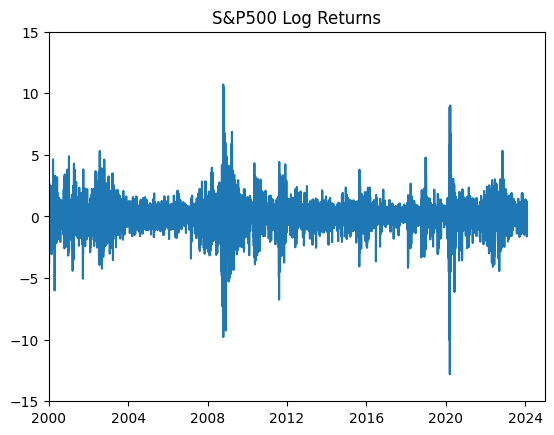

In [77]:
plt.figure()
plt.plot(dates,returns)
plt.xlim([datetime(2000, 1, 1), datetime(2025, 1, 1)])
plt.ylim([-15, 15])
plt.title('S&P500 Log Returns')
plt.show()

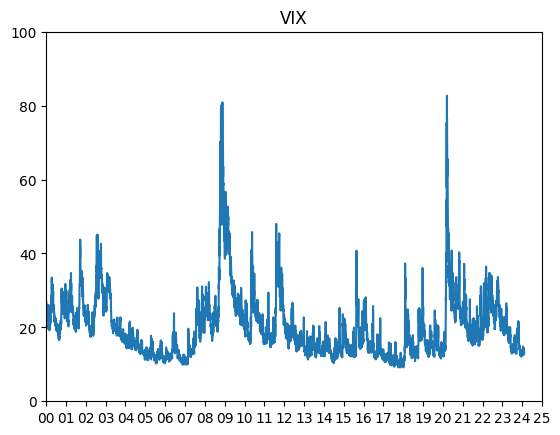

In [78]:
plt.figure()
plt.plot(dates,vix)
plt.title('VIX')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xticks(rotation=0)
plt.xlim([datetime(2000, 1, 1), datetime(2025, 1, 1)])
plt.ylim([0, 100])
plt.show()

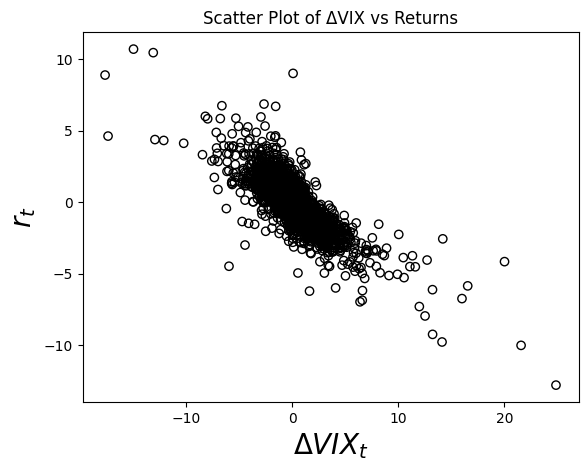

In [79]:
plt.figure()
plt.scatter(np.diff(vix), returns[1:], edgecolors='k', facecolors='none')
plt.xlabel(r'$\Delta VIX_t$', fontsize=20)
plt.ylabel(r'$r_t$', fontsize=20)
plt.title('Scatter Plot of ΔVIX vs Returns')
plt.show()

In [ ]:
def negative_log_likelihood_garch(params, returns):
    """
    Computes the negative log-likelihood for a standard GARCH(1,1) model.

    Parameters:
        params (list or np.ndarray): Model parameters [mu, omega, alpha, beta].
        returns (np.ndarray): Time series of asset returns.

    Returns:
        float: Negative log-likelihood value.
    """
    mu, omega, alpha, beta = params
    T = len(returns)
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(returns)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (returns[t-1] - mu)**2 + beta * sigma2[t-1]
    return 0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma2) + ((returns - mu)**2) / sigma2)


In [ ]:
def filter_garch(params, returns):
    """
    Computes the conditional variances from a GARCH(1,1) model.

    Parameters:
        params (list or np.ndarray): Model parameters [mu, omega, alpha, beta].
        returns (np.ndarray): Time series of asset returns.

    Returns:
        np.ndarray: Conditional variance series.
    """
    mu, omega, alpha, beta = params
    T = len(returns)
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(returns)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (returns[t-1] - mu)**2 + beta * sigma2[t-1]
    return sigma2

In [ ]:
starting_values = [np.mean(returns), 0.002, 0.010, 0.085]
bounds = [(-np.inf, np.inf), (0, np.inf), (0, np.inf), (0, np.inf)]
result = minimize(negative_log_likelihood_garch, starting_values, args=(returns,), method='L-BFGS-B', bounds=bounds)
ML_parameters = result.x
print("Estimated parameters:", ML_parameters)

Estimated parameters: [0.14619326 0.03494458 0.68018165 0.59012306]


C:\Users\bjjcs\AppData\Local\Temp\ipykernel_26712\2772943014.py:7: RuntimeWarning: overflow encountered in scalar multiply
  sigma2[t] = omega + alpha * (returns[t-1] - mu)**2 + beta * sigma2[t-1]
C:\Users\bjjcs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


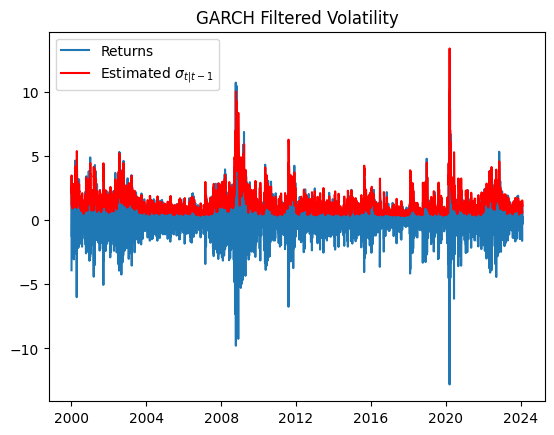

In [ ]:
sigma2 = filter_garch(ML_parameters, returns)
plt.figure()
plt.plot(dates, returns, label='Returns')
plt.plot(dates, np.sqrt(sigma2), 'r', label='Estimated $\sigma_{t|t-1}$')
plt.legend()
plt.title('GARCH Filtered Volatility')
plt.show()

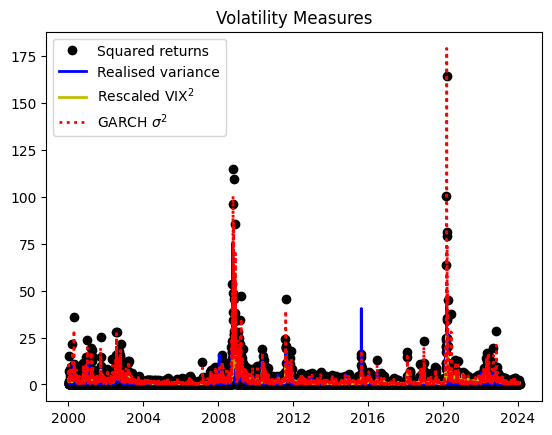

In [84]:
plt.figure()
plt.plot(dates, returns**2, 'ok', label='Squared returns')
plt.plot(dates, rv5, 'b', linewidth=2, label='Realised variance')
plt.plot(dates, (1/250) * vix**2, 'y', linewidth=2, label='Rescaled VIX$^2$')
plt.plot(dates, sigma2, 'r:', linewidth=2, label='GARCH $\sigma^2$')
plt.legend()
plt.title('Volatility Measures')
plt.show()



In [ ]:
mu_ML = ML_parameters[0]
implied_epsilon = (returns - mu_ML) / np.sqrt(sigma2)
print("Mean of shocks:", np.mean(implied_epsilon))
print("Variance of shocks:", np.var(implied_epsilon))

print("Mean squared returns:", np.mean(returns**2))
print("1.4 * mean(realised variance):", 1.4 * np.mean(rv5))

Mean of shocks: -0.13896929633095514
Variance of shocks: 0.8441750570906645
Mean squared returns: 1.4993359007053693
1.4 * mean(realised variance): 1.4862962715642034


In [ ]:
def SRGARCH(params, r_t, x_t):
    """
    Computes the negative log-likelihood for the SR-GARCH model with an exogenous variable.

    Parameters:
    params (list or np.ndarray): Model parameters [mu, omega, alpha, beta, gamma, xi, phi, tau2, sigma_u2].
    r_t (np.ndarray): Time series of asset returns.
    x_t (np.ndarray): Exogenous variable time series (e.g., realized variance).

    Returns:
    float: Negative log-likelihood value.
    """

    mu, omega, alpha, beta, gamma, xi, phi, tau2, sigma_u2 = params

    T = len(r_t)
    sigma2 = np.zeros(T)
    eps = np.zeros(T)
    loglik = 0.0

    unconditional_var = omega / (1 - alpha - beta) if (alpha + beta) < 1 else np.var(r_t)
    sigma2[0] = unconditional_var
    eps[0] = (r_t[0] - mu) / np.sqrt(sigma2[0])

    for t in range(1, T):
        eps[t-1] = (r_t[t-1] - mu) / np.sqrt(sigma2[t - 1])

        sigma2[t] = (
            omega +
            alpha * (r_t[t - 1] - mu) ** 2 +
            beta * sigma2[t - 1] +
            gamma * x_t[t - 1]
        )

        tau_eps = tau2 * (eps[t-1] ** 2 - 1)
        x_hat = xi + phi * sigma2[t-1] + tau_eps

        ll_ret = 0.5 * (np.log(2 * np.pi) + np.log(sigma2[t-1]) + ((r_t[t-1] - mu) ** 2) / sigma2[t-1])
        ll_meas = 0.5 * (np.log(2 * np.pi) + np.log(sigma_u2) + ((x_t[t-1] - x_hat) ** 2) / sigma_u2)
        loglik += ll_ret + ll_meas

    return loglik

initial_params = [
    np.mean(returns),  # mu
    0.01,              # omega
    0.1,               # alpha
    0.85,              # beta
    0.05,              # gamma
    0.1,               # xi
    0.9,               # phi
    0.1,               # tau2
    0.1                # sigma_u^2
]

bounds = [
    (None, None),    # mu
    (1e-6, None),    # omega
    (0, 1),          # alpha
    (0, 1),          # beta
    (0, None),       # gamma
    (None, None),    # xi
    (0, 1),          # phi
    (None, None),    # tau2
    (1e-6, None)     # sigma_u^2
]

result = minimize(SRGARCH, initial_params, args=(returns, rv5), bounds=bounds)

if result.success:
    print("Estimated parameters:")
    param_names = ['mu', 'omega', 'alpha', 'beta', 'gamma', 'xi', 'phi', 'tau2', 'sigma_u^2']
    for name, val in zip(param_names, result.x):
        print(f"{name}: {val:.6f}")
    optimized_params = result.x.tolist()

    loglik_value = SRGARCH(optimized_params, returns, rv5)
    print("Log-likelihood value at estimated parameters:", loglik_value)
else:
    print("Optimization failed:", result.message)


Estimated parameters:
mu: 0.056323
omega: 0.095040
alpha: 0.097816
beta: 0.519472
gamma: 0.403014
xi: 0.015534
phi: 0.751406
tau2: 0.167337
sigma_u^2: 2.389869
Log-likelihood value at estimated parameters: 19454.422377887444


In [ ]:
def ARGARCH(params, r_t, x_t):
    """
    Computes the negative log-likelihood for the AR-GARCH model with an exogenous variable.

    Parameters:
        params (list or np.ndarray): Model parameters [mu, omega, alpha, beta, gamma, xi, phi, tau1, tau2, sigma_u2].
        r_t (np.ndarray): Time series of asset returns.
        x_t (np.ndarray): Exogenous variable time series (e.g., realized variance).

    Returns:
        float: Negative log-likelihood value.
    """

    mu, omega, alpha, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = params

    T = len(r_t)
    sigma2 = np.zeros(T)
    eps = np.zeros(T)
    loglik = 0.0

    sigma2[0] = np.var(r_t)
    eps[0] = (r_t[0] - mu) / np.sqrt(sigma2[0])

    for t in range(1, T):
        eps[t-1] = (r_t[t-1] - mu) / np.sqrt(sigma2[t-1])

        sigma2[t] = (
            omega +
            alpha * (r_t[t-1] - mu) ** 2 +
            beta * sigma2[t-1] +
            gamma * x_t[t-1]
        )

        x_hat = (
            xi +
            phi * sigma2[t-1] +
            tau1 * eps[t-1] +
            tau2 * (eps[t-1] ** 2 - 1)
        )

        ll_ret = 0.5 * (np.log(2 * np.pi) + np.log(sigma2[t-1]) + (r_t[t-1] - mu) ** 2 / sigma2[t-1])
        ll_meas = 0.5 * (np.log(2 * np.pi) + np.log(sigma_u2) + (x_t[t-1] - x_hat) ** 2 / sigma_u2)        
        loglik += ll_ret + ll_meas

    return loglik

initial_params = [
    np.mean(returns),  # mu
    0.001,              # omega
    0.01,               # alpha
    0.085,              # beta
    0.005,              # gamma
    0.01,               # xi
    0.09,               # phi
    0.01,               # tau1
    0.01,               # tau2
    0.01                # sigma_u^2
]

bounds = [
    (None, None),    # mu
    (1e-6, None),    # omega
    (0, 1),          # alpha
    (0, 1),          # beta
    (0, None),       # gamma
    (None, None),    # xi
    (0, 1),          # phi
    (None, None),    # tau1
    (None, None),    # tau2
    (1e-6, None)     # sigma_u^2
]

result = minimize(ARGARCH, initial_params, args=(returns, rv5), bounds=bounds)

if result.success:
    print("Estimated parameters:")
    param_names = ['mu', 'omega', 'alpha', 'beta', 'gamma', 'xi', 'phi', 'tau1', 'tau2', 'sigma_u^2']
    for name, val in zip(param_names, result.x):
        print(f"{name}: {val:.6f}")
    
    optimized_params = result.x.tolist()
    loglik_value = ARGARCH(optimized_params, returns, rv5)
    print("Log-likelihood value at estimated parameters:", loglik_value)

else:
    print("Optimization failed:", result.message)


Estimated parameters:
mu: 0.039682
omega: 0.057681
alpha: 0.093449
beta: 0.523073
gamma: 0.466907
xi: 0.068736
phi: 0.680252
tau1: -0.142740
tau2: 0.156317
sigma_u^2: 2.382405
Log-likelihood value at estimated parameters: 19375.102769193174


Opdracht 4

In [ ]:
RV_d = rv5
RV_w = pd.Series(RV_d).rolling(window=5, min_periods=5).mean().to_numpy()
RV_m = pd.Series(RV_d).rolling(window=21, min_periods=21).mean().to_numpy()

start = 21
X = np.column_stack([RV_d[start-1:-1], RV_w[start-1:-1], RV_m[start-1:-1]])
Y = RV_d[start:]

X_const = sm.add_constant(X)
har_model = sm.OLS(Y, X_const).fit()

print("HAR-RV parameters (const, β_d, β_w, β_m):")
print(har_model.params.round(6))

x_last = [RV_d[-1], np.mean(RV_d[-5:]), np.mean(RV_d[-21:])]
x_last_const = sm.add_constant([x_last], has_constant='add')
har_forecast_1d = har_model.predict(x_last_const)[0]

print("One-day-ahead variance forecast:", har_forecast_1d)

HAR-RV parameters (const, β_d, β_w, β_m):
[0.115858 0.274399 0.523559 0.09233 ]
One-day-ahead variance forecast: 0.4275238518978288


In [ ]:
def nll_agarch(params, returns):
    """
    Computes the negative log-likelihood for an Asymmetric GARCH (AGARCH) model.

    Parameters:
        params (list or np.ndarray): Model parameters [mu, omega, a1, a2, beta].
        returns (np.ndarray): Time series of asset returns.

    Returns:
        float: Negative log-likelihood value.
    """

    mu, omega, a1, a2, beta = params

    if omega <= 0 or min(a1, a2) < 0 or beta < 0:
        return 1e10
    
    T     = len(returns)
    eps   = returns - mu
    sigma2 = np.empty(T)
    sigma2[0] = np.var(returns)          
    
    for t in range(1, T):
        alpha_t  = a1 if eps[t-1] < 0 else a2
        sigma2[t] = omega + alpha_t * eps[t-1]**2 + beta * sigma2[t-1]

        if sigma2[t] <= 0:               
            return 1e10

    ll = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + eps**2 / sigma2)
    return -np.sum(ll)                   

In [ ]:
ratio = 0.50   
T = len(data)
T_est = int(np.floor(ratio * T))
horizons = [1, 5, 21]
idx_1 = slice(None, T_est)               
idx_2 = slice(T_est, None)

In [ ]:
def qlike(y, f):
    """
    Computes the QLIKE (Quasi-Likelihood) loss between actual and forecasted variances.

    Parameters:
        y (np.ndarray or float): Realized variance.
        f (np.ndarray or float): Forecasted variance.

    Returns:
        np.ndarray or float: QLIKE loss value.
    """

    return np.log(f) + y / f

In [ ]:
def mse(y, f):
    """
    Computes the Mean Squared Error (MSE) between actual and forecasted values.

    Parameters:
        y (np.ndarray or float): Actual value(s).
        f (np.ndarray or float): Forecasted value(s).

    Returns:
        np.ndarray or float: Squared error.
    """

    return (y - f) ** 2

In [ ]:
def vix_forecast(vix_today, d):
    """
    Converts the current VIX value into a multi-day variance forecast.

    Parameters:
        vix_today (float): Current VIX level (annualized volatility in percent).
        d (int): Forecast horizon in days.

    Returns:
        float: Forecasted variance over the next d days.
    """

    return d/250.0 * (vix_today ** 2)

In [ ]:
def har_rv_estimate_predict(rv_series, d):
    """
    Estimates a HAR-RV model and generates multi-day realized variance forecasts.

    Parameters:
        rv_series (np.ndarray): Daily realized variance series.
        d (int): Forecast horizon in days.

    Returns:
        tuple: 
            f_dates (np.ndarray): Dates corresponding to the forecast period.
            pv (np.ndarray): Forecasted cumulative realized variance over d days.
    """

    rv_d = rv_series
    rv_w = pd.Series(rv_series).rolling(5).mean().to_numpy()
    rv_m = pd.Series(rv_series).rolling(21).mean().to_numpy()

    X = np.column_stack([np.ones(T), rv_d, rv_w, rv_m])
    y = pd.Series(rv_series).shift(-d).rolling(d).sum().to_numpy()

    valid = np.all(np.isfinite(X), axis=1) & np.isfinite(y)

    mask_est = valid & (np.arange(T) < T_est)
    beta = np.linalg.lstsq(X[mask_est], y[mask_est], rcond=None)[0]
    mask_oos = valid & (np.arange(T) >= T_est)
    pv  = (X[mask_oos] @ beta)                  
    f_dates = data['date'].values[mask_oos]

    return f_dates, pv


In [ ]:
def agarch_forecasts(returns, idx_est, idx_oos, d_list):
    """
    Estimates an Asymmetric GARCH (AGARCH) model and produces multi-step variance forecasts.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        idx_est (slice or np.ndarray): Indices for in-sample estimation.
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        d_list (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        tuple:
            dates (np.ndarray): Dates corresponding to the forecast window.
            pv_dict (dict): Forecasted variances keyed by horizon.
    """

    returns_est = returns[idx_est]
    initial_params = [np.mean(returns_est), 0.01, 0.05, 0.05, 0.9]
    bounds = [(None, None), (1e-6, None), (0, 1), (0, 1), (0, 1)]

    result = minimize(nll_agarch, initial_params, args=(returns_est,), bounds=bounds)
    params = result.x
    mu, omega, a1, a2, beta = params

    eps = returns - mu
    sigma2 = np.empty(len(returns) + max(d_list))
    sigma2[0] = np.var(returns)

    for t in range(1, len(returns)):
        alpha_t = a1 if eps[t-1] < 0 else a2
        sigma2[t] = omega + alpha_t * eps[t-1]**2 + beta * sigma2[t-1]

    pv_dict = {}
    for d in d_list:
        forecasts = []
        for t in range(*idx_oos.indices(len(returns))):
            sig = sigma2[t]
            for h in range(d):
                sig = omega + (a1 + a2) / 2 * np.var(returns) + beta * sig
            forecasts.append(d * sig)
        pv_dict[d] = np.array(forecasts)

    dates = data['date'].values[idx_oos]
    return dates, pv_dict


In [ ]:
def argarch_forecasts(returns, rv, idx_est, idx_oos, d_list):
    """
    Estimates an AR-GARCH model with an exogenous variable and produces multi-step variance forecasts.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        rv (np.ndarray): Exogenous variable (e.g., realized variance).
        idx_est (slice or np.ndarray): Indices for in-sample estimation.
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        d_list (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        tuple:
            dates (np.ndarray): Dates corresponding to the forecast window.
            pv_dict (dict): Forecasted variances keyed by horizon.
    """

    r_est = returns[idx_est]
    x_est = rv[idx_est]

    initial_params = [
        np.mean(r_est),  # mu
        0.001,           # omega
        0.01,            # alpha
        0.085,           # beta
        0.005,           # gamma
        0.01,            # xi
        0.09,            # phi
        0.01,            # tau1
        0.01,            # tau2
        0.01             # sigma_u^2
    ]

    bounds = [
        (None, None),    # mu
        (1e-6, None),    # omega
        (0, 1),          # alpha
        (0, 1),          # beta
        (0, None),       # gamma
        (None, None),    # xi
        (0, 1),          # phi
        (None, None),    # tau1
        (None, None),    # tau2
        (1e-6, None)     # sigma_u^2
    ]

    result = minimize(ARGARCH, initial_params, args=(r_est, x_est), bounds=bounds)
    if not result.success:
        raise RuntimeError("ARGARCH estimation failed: " + result.message)

    mu, omega, alpha, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = result.x
    eps = returns - mu

    T = len(returns)
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(r_est)

    for t in range(1, T):
        e_prev = eps[t - 1]
        sigma2[t] = omega + alpha * e_prev**2 + beta * sigma2[t - 1] + gamma * rv[t - 1]

    pv_dict = {}
    for d in d_list:
        forecasts = []
        for t in range(*idx_oos.indices(T)):
            sig = sigma2[t]
            for h in range(d):
                sig = omega + alpha * np.var(returns) + beta * sig + gamma * (
                    xi + phi * sig  
                )
            forecasts.append(d * sig)
        pv_dict[d] = np.array(forecasts)

    dates = data['date'].values[idx_oos]
    return dates, pv_dict


In [ ]:
def SGARCH(params, r_t):
    """
    Computes the negative log-likelihood for a standard GARCH(1,1) model (with placeholder for extended param set).

    Parameters:
        params (list or np.ndarray): Model parameters [mu, omega, alpha, beta, _] — last element is ignored.
        r_t (np.ndarray): Time series of asset returns.

    Returns:
        float: Negative log-likelihood value.
    """

    mu, omega, alpha, beta, _ = params  

    T = len(r_t)
    sigma2 = np.zeros(T)
    eps = r_t - mu

    sigma2[0] = np.var(r_t)

    loglik = 0.0
    for t in range(1, T):
        sigma2[t] = omega + alpha * eps[t - 1] ** 2 + beta * sigma2[t - 1]
        loglik += 0.5 * (np.log(2 * np.pi) + np.log(sigma2[t]) + eps[t] ** 2 / sigma2[t])
    return loglik


In [ ]:
def sgarch_forecasts(returns, idx_est, idx_oos, d_list):
    """
    Estimates a standard GARCH(1,1) model and produces multi-step variance forecasts.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        idx_est (slice or np.ndarray): Indices for in-sample estimation.
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        d_list (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        tuple:
            dates (np.ndarray): Dates corresponding to the forecast window.
            pv_dict (dict): Forecasted variances keyed by horizon.
    """

    returns_est = returns[idx_est]

    initial_params = [np.mean(returns_est), 0.01, 0.05, 0.9]
    bounds = [(None, None), (1e-6, None), (0, 1), (0, 1)]

    result = minimize(negative_log_likelihood_garch, initial_params, args=(returns_est,), bounds=bounds)
    mu, omega, alpha, beta = result.x

    eps = returns - mu
    sigma2 = np.zeros(len(returns))
    sigma2[0] = np.var(returns)

    for t in range(1, len(returns)):
        sigma2[t] = omega + alpha * eps[t-1]**2 + beta * sigma2[t-1]

    pv_dict = {}
    for d in d_list:
        forecasts = []
        for t in range(*idx_oos.indices(len(returns))):
            sig = sigma2[t]
            for h in range(d):
                sig = omega + alpha * np.var(returns) + beta * sig
            forecasts.append(d * sig)
        pv_dict[d] = np.array(forecasts)

    dates = data['date'].values[idx_oos]
    return dates, pv_dict


In [ ]:
def rgarch_forecasts(returns, rv5, idx_est, idx_oos, d_list):
    """
    Estimates a Realized GARCH (RGARCH) model with realized variance input and produces multi-step variance forecasts.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        rv5 (np.ndarray): Realized variance (e.g., 5-minute RV).
        idx_est (slice or np.ndarray): Indices for in-sample estimation.
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        d_list (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        tuple:
            dates (np.ndarray): Dates corresponding to the forecast window.
            pv_dict (dict): Forecasted variances keyed by horizon.
    """

    returns_est = returns[idx_est]
    rv5_est = rv5[idx_est]

    initial_params = [
        np.mean(returns_est), 0.001, 0.01, 0.085, 0.005,
        0.01, 0.09, 0.01, 0.01, 0.01
    ]
    bounds = [
        (None, None), (1e-6, None), (0, 1), (0, 1), (0, None),
        (None, None), (0, 1), (None, None), (None, None), (1e-6, None)
    ]

    result = minimize(ARGARCH, initial_params, args=(returns_est, rv5_est), bounds=bounds)
    params = result.x

    mu, omega, alpha, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = params
    T = len(returns)
    sigma2 = np.zeros(T + max(d_list))
    sigma2[0] = np.var(returns)
    eps = np.zeros(T + max(d_list))

    for t in range(1, T):
        eps[t-1] = (returns[t-1] - mu) / np.sqrt(sigma2[t-1])
        sigma2[t] = omega + alpha * (returns[t-1] - mu)**2 + beta * sigma2[t-1] + gamma * rv5[t-1]

    pv_dict = {}
    for d in d_list:
        forecasts = []
        for t in range(*idx_oos.indices(T)):
            sig = sigma2[t]
            for h in range(d):
                sig = omega + alpha * np.var(returns) + beta * sig + gamma * np.mean(rv5)
            forecasts.append(d * sig)
        pv_dict[d] = np.array(forecasts)

    dates = data['date'].values[idx_oos]
    return dates, pv_dict

In [ ]:
def egarch_negative_log_likelihood(params, returns):
    """
    Computes the negative log-likelihood for an EGARCH(1,1) model.

    Parameters:
        params (list or np.ndarray): Model parameters [mu, omega, alpha, beta, gamma].
        returns (np.ndarray): Time series of asset returns.

    Returns:
        float: Negative log-likelihood value.
    """

    mu, omega, alpha, beta, gamma = params
    T = len(returns)
    log_sigma2 = np.zeros(T)
    eps = returns - mu

    log_sigma2[0] = np.log(np.var(returns))
    SQRT_2_PI = np.sqrt(2 / np.pi)
    max_log_sigma = 50
    min_log_sigma = -50

    for t in range(1, T):
        sigma_prev = np.exp(0.5 * log_sigma2[t-1])
        z = eps[t-1] / sigma_prev
        log_sigma2[t] = (omega
                         + alpha * (np.abs(z) - SQRT_2_PI)
                         + beta * log_sigma2[t-1]
                         + gamma * z)
        log_sigma2[t] = np.clip(log_sigma2[t], min_log_sigma, max_log_sigma)

    if np.any(np.isnan(log_sigma2)) or np.any(np.isinf(log_sigma2)):
        return 1e10  # penalize

    loglikelihood = -0.5 * (np.log(2 * np.pi) + log_sigma2 + eps**2 / np.exp(log_sigma2))
    return -np.sum(loglikelihood)

starting_values = [np.mean(returns), 0.02, 0.10, 0.85, 0.0]
print('NLL at start:', egarch_negative_log_likelihood(starting_values, returns))

bounds = [(-1, 1), (-10, 10), (0, 1), (0, 1), (-100, 100)]
result = differential_evolution(egarch_negative_log_likelihood, bounds=bounds, args=(returns,))

ML_parameters = result.x  # Estimated parameters
print('Estimated parameters:', ML_parameters)
print('Loglikelihood:', egarch_negative_log_likelihood(ML_parameters, returns))


NLL at start: 9030.855191125745
Estimated parameters: [ 2.83171404e-02  1.83854687e-04  1.50953527e-01  9.76672728e-01
 -1.16422309e-01]
Loglikelihood: 8224.139230301666


In [ ]:
def filter_egarch(params, returns):
    """
    Computes the conditional variances from an EGARCH(1,1) model.

    Parameters:
        params (list or np.ndarray): Model parameters [mu, omega, alpha, beta, gamma].
        returns (np.ndarray): Time series of asset returns.

    Returns:
        np.ndarray: Conditional variance series.
    """

    mu, omega, alpha, beta, gamma = params
    T = len(returns)
    logsigma2 = np.zeros(T)
    eps = returns - mu
    logsigma2[0] = np.log(np.var(returns))
    
    for t in range(1, T):
        logsigma2[t] = omega + alpha * abs(eps[t-1] / np.exp(0.5 * logsigma2[t-1])) + beta * logsigma2[t-1] + gamma * eps[t-1] / np.exp(0.5 * logsigma2[t-1])
    return np.exp(logsigma2)

sigma2_filtered = filter_egarch(ML_parameters, returns)

In [ ]:
def egarch_forecast(returns, params, idx_oos, horizons):
    """
    Generates filtered variances and multi-step variance forecasts from an EGARCH(1,1) model.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        params (list or np.ndarray): Model parameters [mu, omega, alpha, beta, gamma].
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        horizons (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        tuple:
            sigma2 (np.ndarray): One-step-ahead filtered variances.
            pv_dict (dict): Forecasted variances keyed by horizon.
    """

    mu, omega, alpha, beta, gamma = params
    T = len(returns)
    log_sigma2 = np.zeros(T)
    eps = returns - mu
    log_sigma2[0] = np.log(np.var(returns))
    SQRT_2_PI = np.sqrt(2 / np.pi)

    for t in range(1, T):
        sigma_prev = np.exp(0.5 * log_sigma2[t-1])
        z = eps[t-1] / sigma_prev
        log_sigma2[t] = omega + alpha * (np.abs(z) - SQRT_2_PI) + beta * log_sigma2[t-1] + gamma * z

    sigma2 = np.exp(log_sigma2)
    pv_dict = {}
    for d in horizons:
        forecasts = []
        for t in range(*idx_oos.indices(T)):
            log_sig = log_sigma2[t]
            for h in range(d):
                log_sig = omega + alpha * (np.sqrt(2 / np.pi) - SQRT_2_PI) + beta * log_sig  
            forecasts.append(d * np.exp(log_sig))  
        pv_dict[d] = np.array(forecasts)
    return sigma2, pv_dict


In [ ]:
def garchx_forecasts(returns, epu, idx_est, idx_oos, d_list):
    """
    Fits a GARCH-X model with an exogenous EPU variable and generates multi-step volatility forecasts.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        epu (np.ndarray): Exogenous variable (e.g., EPU index).
        idx_est (slice or np.ndarray): Indices for in-sample estimation.
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        d_list (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        dates (np.ndarray): Dates corresponding to the forecast window.
        pv_dict (dict): Forecasted variances keyed by horizon.
    """
    r_est = returns[idx_est]
    epu_est = epu[idx_est]

    def nll_garchx(params, returns_epu):
        returns, epu = returns_epu
        mu, omega, alpha, beta, gamma = params
        T = len(returns)
        sigma2 = np.zeros(T)
        eps = returns - mu
        sigma2[0] = np.var(returns)
        for t in range(1, T):
            sigma2[t] = max(omega + alpha * eps[t-1]**2 + beta * sigma2[t-1] + gamma * epu[t-1], 1e-8)
        sigma2 = np.maximum(sigma2, 1e-8)
        loglik = 0.5 * np.sum(np.log(2*np.pi) + np.log(sigma2) + eps**2 / sigma2)
        return loglik

    bounds = [(-10, 10), (1e-6, 10), (0, 1), (0, 1), (-1, 1)]
    returns_epu = (r_est, epu_est)
    result = differential_evolution(nll_garchx, bounds=bounds, args=(returns_epu,))

    mu, omega, alpha, beta, gamma = result.x

    T = len(returns)
    sigma2 = np.zeros(T)
    eps = returns - mu
    sigma2[0] = np.var(r_est)
    for t in range(1, T):
        sigma2[t] = omega + alpha * eps[t-1]**2 + beta * sigma2[t-1] + gamma * epu[t-1]

    pv_dict = {}
    for d in d_list:
        forecasts = []
        for t in range(*idx_oos.indices(T)):
            sig = sigma2[t]
            for h in range(d):
                sig = omega + alpha * np.var(returns) + beta * sig + gamma * np.mean(epu[idx_est])  # assume average future EPU
            forecasts.append(d * sig)
        pv_dict[d] = np.array(forecasts)

    dates = data['date'].values[idx_oos]
    return dates, pv_dict


In [ ]:
def nll_agarchx(params, r, epu_vals):
    """
    Computes the negative log-likelihood for an Asymmetric GARCH-X model with an exogenous variable.

    Parameters:
        params (list or np.ndarray): Model parameters [mu, omega, alpha1, alpha2, beta, gamma].
        r (np.ndarray): Time series of asset returns.
        epu_vals (np.ndarray): Exogenous variable values (e.g., EPU index).

    Returns:
        float: Negative log-likelihood value.
    """

    mu, omega, alpha1, alpha2, beta, gamma = params
    T = len(r)
    sigma2 = np.zeros(T)
    eps = r - mu
    sigma2[0] = np.var(r)
    for t in range(1, T):
        ind = 1 if eps[t-1] < 0 else 0
        sigma2[t] = max(omega + (alpha1 + alpha2 * ind) * eps[t-1]**2 + beta * sigma2[t-1] + gamma * epu_vals[t-1], 1e-8)
    sigma2 = np.maximum(sigma2, 1e-8)
    loglik = 0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma2) + eps**2 / sigma2)
    return loglik

In [ ]:
def agarchx_epu_forecasts(returns, epu, idx_est, idx_oos, d_list):
    """
    Estimates an Asymmetric GARCH-X model with an exogenous EPU variable and produces multi-step variance forecasts.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        epu (np.ndarray): Exogenous variable (e.g., Economic Policy Uncertainty index).
        idx_est (slice or np.ndarray): Indices for in-sample estimation.
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        d_list (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        tuple:
            dates (np.ndarray): Dates corresponding to the forecast window.
            pv_dict (dict): Forecasted variances keyed by horizon.
    """

    r_est = returns[idx_est]
    epu_est = epu[idx_est]

    init_vals = [np.mean(r_est), 0.01, 0.05, 0.05, 0.9, 0.0]
    bounds = [(None, None), (1e-6, 10), (0.001, 1), (0, 1), (0.001, 1), (-1, 1)]

    result = minimize(nll_agarchx, init_vals, args=(r_est, epu_est), method='L-BFGS-B', bounds=bounds)
    mu, omega, alpha1, alpha2, beta, gamma = result.x

    T = len(returns)
    sigma2 = np.zeros(T)
    eps = returns - mu
    sigma2[0] = np.var(r_est)
    for t in range(1, T):
        ind = 1 if eps[t-1] < 0 else 0
        sigma2[t] = omega + (alpha1 + alpha2 * ind) * eps[t-1]**2 + beta * sigma2[t-1] + gamma * epu[t-1]
        sigma2[t] = max(sigma2[t], 1e-8)

    pv_dict = {}
    avg_epu = np.mean(epu_est)
    for d in d_list:
        forecasts = []
        for t in range(*idx_oos.indices(T)):
            sig = sigma2[t]
            for h in range(d):
                sig = omega + (alpha1 + alpha2) / 2 * np.var(returns) + beta * sig + gamma * avg_epu
                sig = max(sig, 1e-8)
            forecasts.append(d * sig)
        pv_dict[d] = np.array(forecasts)

    dates = data['date'].values[idx_oos]
    return dates, pv_dict


In [ ]:
def garchx_vix_forecasts(returns, vix, idx_est, idx_oos, d_list):
    """
    Estimates a GARCH-X model with VIX as an exogenous variable and produces multi-step variance forecasts.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        vix (np.ndarray): Exogenous variable (e.g., VIX index values).
        idx_est (slice or np.ndarray): Indices for in-sample estimation.
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        d_list (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        tuple:
            dates (np.ndarray): Dates corresponding to the forecast window.
            pv_dict (dict): Forecasted variances keyed by horizon.
    """

    r_est = returns[idx_est]
    vix_est = vix[idx_est]

    def nll_garchx_vix(params, r, vix_vals):
        mu, omega, alpha, beta, gamma = params
        T = len(r)
        sigma2 = np.zeros(T)
        eps = r - mu
        sigma2[0] = np.var(r)
        for t in range(1, T):
            sigma2[t] = max(omega + alpha * eps[t-1]**2 + beta * sigma2[t-1] + gamma * vix_vals[t-1], 1e-8)
        sigma2 = np.maximum(sigma2, 1e-8)
        loglik = 0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma2) + eps**2 / sigma2)
        return loglik

    init_vals = [np.mean(r_est), 0.01, 0.05, 0.85, 0.0]
    bounds = [(-1, 1), (1e-6, 2), (0, 1), (0.01, 1), (0, 1)]

    result = minimize(nll_garchx_vix, init_vals, args=(r_est, vix_est), method='L-BFGS-B', bounds=bounds)
    mu, omega, alpha, beta, gamma = result.x
    T = len(returns)
    sigma2 = np.zeros(T)
    eps = returns - mu
    sigma2[0] = np.var(r_est)
    for t in range(1, T):
        sigma2[t] = omega + alpha * eps[t-1]**2 + beta * sigma2[t-1] + gamma * vix[t-1]
        sigma2[t] = max(sigma2[t], 1e-8)

    pv_dict = {}
    avg_vix = np.mean(vix_est)
    for d in d_list:
        forecasts = []
        for t in range(*idx_oos.indices(T)):
            sig = sigma2[t]
            for h in range(d):
                sig = omega + alpha * np.var(returns) + beta * sig + gamma * avg_vix
                sig = max(sig, 1e-8)
            forecasts.append(d * sig)
        pv_dict[d] = np.array(forecasts)

    dates = data['date'].values[idx_oos]
    return dates, pv_dict


In [ ]:
def agarchx_vix_forecasts(returns, vix, idx_est, idx_oos, d_list):
    """
    Estimates an Asymmetric GARCH-X model with VIX as an exogenous variable and produces multi-step variance forecasts.

    Parameters:
        returns (np.ndarray): Time series of asset returns.
        vix (np.ndarray): Exogenous variable (e.g., VIX index values).
        idx_est (slice or np.ndarray): Indices for in-sample estimation.
        idx_oos (slice or np.ndarray): Indices for out-of-sample forecasting.
        d_list (list of int): Forecast horizons (e.g., 1-day, 5-day).

    Returns:
        tuple:
            dates (np.ndarray): Dates corresponding to the forecast window.
            pv_dict (dict): Forecasted variances keyed by horizon.
    """

    r_est = returns[idx_est]
    vix_est = vix[idx_est]

    def nll_agarchx_vix(params, r, vix_vals):
        mu, omega, alpha1, alpha2, beta, gamma = params
        T = len(r)
        sigma2 = np.zeros(T)
        eps = r - mu
        sigma2[0] = np.var(r)
        for t in range(1, T):
            ind = 1 if eps[t-1] < 0 else 0
            sigma2[t] = max(
                omega + (alpha1 + alpha2 * ind) * eps[t-1]**2 + beta * sigma2[t-1] + gamma * vix_vals[t-1], 1e-8)
        sigma2 = np.maximum(sigma2, 1e-8)
        loglik = 0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma2) + eps**2 / sigma2)
        return loglik

    init_vals = [np.mean(r_est), 0.01, 0.05, 0.05, 0.9, 0.0]
    bounds = [(0, 10), (1e-6, 10), (0, 1), (0, 1), (0.001, 1), (0, 1)]

    result = minimize(nll_agarchx_vix, init_vals, args=(r_est, vix_est), method='L-BFGS-B', bounds=bounds)
    mu, omega, alpha1, alpha2, beta, gamma = result.x

    T = len(returns)
    sigma2 = np.zeros(T)
    eps = returns - mu
    sigma2[0] = np.var(r_est)
    for t in range(1, T):
        ind = 1 if eps[t-1] < 0 else 0
        sigma2[t] = max(
            omega + (alpha1 + alpha2 * ind) * eps[t-1]**2 + beta * sigma2[t-1] + gamma * vix[t-1], 1e-8)

    pv_dict = {}
    avg_vix = np.mean(vix_est)
    for d in d_list:
        forecasts = []
        for t in range(*idx_oos.indices(T)):
            sig = sigma2[t]
            for h in range(d):
                sig = omega + (alpha1 + alpha2) / 2 * np.var(returns) + beta * sig + gamma * avg_vix
                sig = max(sig, 1e-8)
            forecasts.append(d * sig)
        pv_dict[d] = np.array(forecasts)

    dates = data['date'].values[idx_oos]
    return dates, pv_dict


In [ ]:
out = []

for d in horizons:
    v_dates = data['date'].values[idx_2]
    v_pv = vix_forecast(vix[idx_2], d)
    out.append(pd.DataFrame({'date': v_dates, 'model': f'VIX_{d}', 'PV': v_pv}))

    h_dates, h_pv = har_rv_estimate_predict(rv5, d)
    out.append(pd.DataFrame({'date': h_dates, 'model': f'HAR_{d}', 'PV': h_pv}))

model_calls = [
    ('AGARCH', agarch_forecasts(returns, idx_1, idx_2, horizons)),
    ('ARGARCH', argarch_forecasts(returns, rv5, idx_1, idx_2, horizons)),
    ('SRGARCH', rgarch_forecasts(returns, rv5, idx_1, idx_2, horizons)),
    ('SGARCH', sgarch_forecasts(returns, idx_1, idx_2, horizons)),
    ('GARCHX_EPU', garchx_forecasts(returns, epu, idx_1, idx_2, horizons)),
    ('AGARCHX_EPU', agarchx_epu_forecasts(returns, epu, idx_1, idx_2, horizons)),
    ('GARCHXVIX', garchx_vix_forecasts(returns, vix, idx_1, idx_2, horizons)),
    ('AGARCHXVIX', agarchx_vix_forecasts(returns, vix, idx_1, idx_2, horizons)),
]

for model_name, (dates, pv_dict) in model_calls:
    for d in horizons:
        out.append(pd.DataFrame({'date': dates, 'model': f'{model_name}_{d}', 'PV': pv_dict[d]}))

eg_sigma2, eg_pv_dict = egarch_forecast(returns, ML_parameters, idx_2, horizons)
eg_dates = data['date'].values[idx_2]
for d in horizons:
    out.append(pd.DataFrame({'date': eg_dates, 'model': f'EGARCH_{d}', 'PV': eg_pv_dict[d]}))

forecasts = pd.concat(out, ignore_index=True).sort_values(['date', 'model'])

In [140]:
tv1 = {d: pd.Series(returns**2).rolling(d).sum().shift(-d) for d in horizons}
tv2 = {d: 1.4 * pd.Series(rv5).rolling(d).sum().shift(-d) for d in horizons}


In [141]:
records = []
for _, row in forecasts.iterrows():
    d = int(row['model'].split('_')[-1])
    t  = np.where(data['date'].values == row['date'])[0][0]
    for tv_name, tv_dict in [('TV1', tv1), ('TV2', tv2)]:
        y = tv_dict[d][t]
        if np.isnan(y):             
            continue
        f = row['PV']
        records.append({
            'date': row['date'], 'model': row['model'], 'horizon': d, 'target': tv_name,
            'MSE': mse(y, f), 'QLIKE': qlike(y, f)
        })

perf = pd.DataFrame.from_records(records)


In [142]:
summary = (
    perf.groupby(['model', 'horizon', 'target'])
        .mean()[['MSE', 'QLIKE']]
        .round(4)
        .reset_index()
)
print(summary)

            model  horizon target        MSE   QLIKE
0    AGARCHXVIX_1        1    TV1    17.8387  0.6698
1    AGARCHXVIX_1        1    TV2     4.7296  0.6201
2   AGARCHXVIX_21       21    TV1  3379.0542  4.1289
3   AGARCHXVIX_21       21    TV2  1498.2642  4.0499
4    AGARCHXVIX_5        5    TV1   237.4669  2.4321
5    AGARCHXVIX_5        5    TV2    83.7475  2.3912
6        EGARCH_1        1    TV1    17.8460  0.6613
7        EGARCH_1        1    TV2     4.1165  0.5964
8       EGARCH_21       21    TV1  3083.2264  3.9891
9       EGARCH_21       21    TV2  1263.2125  3.8748
10       EGARCH_5        5    TV1   232.8613  2.3540
11       EGARCH_5        5    TV2    75.7965  2.2868


In [ ]:
summary.to_excel('forecast_summary.xlsx', index=False)

In [ ]:
def write_multi_to_excel(df, filename):
    """
    Writes forecast data to an Excel file in wide format with models as columns.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'date', 'model', and 'PV' columns.
        filename (str): Path to the output Excel file.

    Returns:
        None
    """


    wide = (df.pivot(index='date', columns='model', values='PV')
              .reset_index()
              .rename_axis(None, axis=1))
    wide.to_excel(filename, index=False)


lag1 = forecasts[forecasts['model'].str.endswith('_1')]
write_multi_to_excel(lag1, 'lag1_forecasts_all_models.xlsx')

lag5 = forecasts[forecasts['model'].str.endswith('_5')]
write_multi_to_excel(lag5, 'lag5_forecasts_all_models.xlsx')

lag21 = forecasts[forecasts['model'].str.endswith('_21')]
write_multi_to_excel(lag21, 'lag21_forecasts_all_models.xlsx')
